In [35]:
from sdm.utils import set_project_wd
set_project_wd()

Current Working Directory: /Users/matthewwhittle/Data Science/shefflied-bats


In [36]:
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import xarray as xr
import mlflow

Load the boundary file, this is the county of south yorkshire with a buffer applied.

<Axes: >

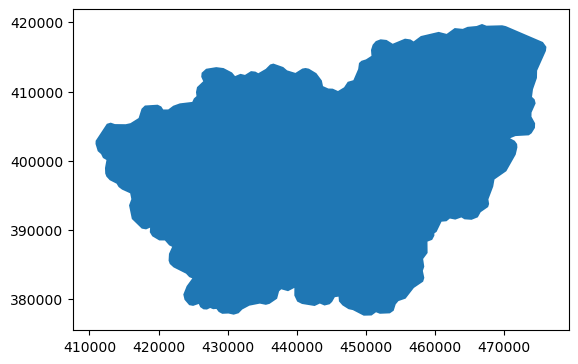

In [37]:
boundary = gpd.read_file('data/processed/boundary.geojson')
boundary.plot()

# Load the datasets

The modelling will use the following datasets:
- Digital Surface Model (DSM) & Digital Terrain Model (DTM) to derive a canopy height model (CHM) which is a key feature in predicting vegetation height
- Sentinel-2 (S2) imagery to classify pixels as vegetation or non-vegetation
- Vegetation height data from the Environment Agency (EA) to train the model. This data has gaps so can't be used directly.

In [38]:
dtm = rxr.open_rasterio('data/processed/dtm-10m.tif')
dsm = rxr.open_rasterio('data/processed/dsm-10m.tif')
veg_height = rxr.open_rasterio('data/processed/vegetation-height.tif')

In [39]:
# Sentinel-2
sentinel_2 = xr.open_mfdataset('data/raw/big-files/sentinel-2/*', combine='by_coords')
sentinel_2

<xarray.Dataset>
Dimensions:      (band: 12, x: 10988, y: 4212)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float64 dask.array<chunksize=(1, 256, 256), meta=np.ndarray>

In [40]:
# From earth engine
band_names = list(sentinel_2.band_data.attrs['long_name'])
sentinel_2 = sentinel_2.band_data.to_dataset(dim='band').rename({i + 1: "s2_" + band_names[i] for i in range(12)})
sentinel_2

<xarray.Dataset>
Dimensions:      (y: 4212, x: 10988)
Coordinates:
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
Data variables:
    s2_B1        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B2        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B3        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B4        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B5        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B6        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B7        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B8        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B8A       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B9        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B11       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B12       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...

# Align the Rasters

To model the data the rasters all need to be aligned so that a pixel in one raster corresponds to the same location as a pixel in another raster.

In [41]:
veg_height = veg_height.rio.reproject_match(sentinel_2)
dsm = dsm.rio.reproject_match(sentinel_2)
dtm = dtm.rio.reproject_match(sentinel_2)

# Drop the band dimension 
veg_height = veg_height.squeeze()
dsm = dsm.squeeze()
dtm = dtm.squeeze()

The arrays need to be converted to datasets with variable names and then stacked with the sentinel image.

In [42]:
dsm = dsm.to_dataset(name='dsm')
dtm = dtm.to_dataset(name='dtm')
veg_height = veg_height.to_dataset(name='veg_height')

In [43]:
image_stack = xr.merge([sentinel_2, dsm, dtm, veg_height])

In [44]:
image_stack

<xarray.Dataset>
Dimensions:      (y: 4212, x: 10988)
Coordinates:
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
    band         int64 1
Data variables: (12/15)
    s2_B1        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B2        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B3        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B4        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B5        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B6        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    ...           ...
    s2_B9        (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B11       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    s2_B12       (y, x) float64 dask.array<chunksize=(256, 256), meta=np.ndarray>
    dsm          (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 29.49 29.49
    dtm          (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 29.49 29.49
    veg_height   (y, x) float32 -9.999e+03 -9.999e+03 -9.999e+03 ... 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...

# Create the training dataset

- Sample the data to train using a subset

In [45]:
image_df = image_stack.to_dask_dataframe()
image_samples = image_df.sample(frac=0.05).compute()
image_samples

,y,x,spatial_ref,band,s2_B1,s2_B2,s2_B3,s2_B4,s2_B5,s2_B6,s2_B7,s2_B8,s2_B8A,s2_B9,s2_B11,s2_B12,dsm,dtm,veg_height
52160,53.670790,-1.100032,0,1,1264.5,1360.0,1522.0,1478.0,1888.0,2591.0,2757.5,2929.0,2918.0,2992.0,2599.0,1999.0,4.345850,4.345646,0.000000
24983,53.670970,-1.567246,0,1,1527.5,1662.5,1788.0,1803.5,2004.5,2396.5,2569.0,2538.5,2734.0,2521.0,2610.0,2287.0,81.487076,81.203941,0.000000
3922,53.671149,-1.485050,0,1,1415.5,1532.5,1762.5,1786.0,2128.5,3430.5,3861.0,4124.0,4162.5,3572.0,3414.0,2559.5,29.174173,29.115999,0.000000
44602,53.670790,-1.778979,0,1,1317.5,1260.0,1424.0,1258.5,1665.0,3351.5,4065.0,4476.5,4255.5,4364.0,2458.0,1658.0,117.995422,117.349228,0.000000
49640,53.670790,-1.326407,0,1,1631.0,1576.0,1938.0,2346.0,2772.0,3139.0,3325.0,3442.0,3601.0,3624.0,2977.0,2662.0,41.381775,41.381302,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46277645,53.292869,-1.192648,0,1,1472.0,1738.0,2006.0,2458.0,2933.0,3236.0,3420.0,3590.0,3709.0,3763.0,3915.0,3173.0,80.652893,80.652893,0.000000
46279887,53.292869,-0.991246,0,1,1429.0,1500.0,1816.0,1778.0,2488.0,2732.0,2880.0,2942.0,3014.0,3105.0,3639.0,3448.0,29.527323,29.527325,0.000000
46264418,53.292958,-1.393781,0,1,1422.0,1425.0,1758.0,1400.0,2313.0,4063.0,4704.0,5288.0,4818.0,4403.0,3483.0,2364.0,-9999.000000,-9999.000000,-9999.000000
46267825,53.292958,-1.087725,0,1,1036.0,1112.0,1231.0,1122.0,1467.0,2837.0,3469.0,3250.0,3700.0,3926.0,1974.0,1417.0,57.247089,50.310680,4.191998


## Exploratory Analysis


In [46]:
# Remove rows with a missing value or -9999
image_samples = image_samples.replace(-9999, np.nan).dropna()

# Calculate the vegetation height
image_samples['chm'] = image_samples['dsm'] - image_samples['dtm']
image_samples

,y,x,spatial_ref,band,s2_B1,s2_B2,s2_B3,s2_B4,s2_B5,s2_B6,s2_B7,s2_B8,s2_B8A,s2_B9,s2_B11,s2_B12,dsm,dtm,veg_height,chm
52160,53.670790,-1.100032,0,1,1264.5,1360.0,1522.0,1478.0,1888.0,2591.0,2757.5,2929.0,2918.0,2992.0,2599.0,1999.0,4.345850,4.345646,0.000000,0.000204
24983,53.670970,-1.567246,0,1,1527.5,1662.5,1788.0,1803.5,2004.5,2396.5,2569.0,2538.5,2734.0,2521.0,2610.0,2287.0,81.487076,81.203941,0.000000,0.283134
3922,53.671149,-1.485050,0,1,1415.5,1532.5,1762.5,1786.0,2128.5,3430.5,3861.0,4124.0,4162.5,3572.0,3414.0,2559.5,29.174173,29.115999,0.000000,0.058174
44602,53.670790,-1.778979,0,1,1317.5,1260.0,1424.0,1258.5,1665.0,3351.5,4065.0,4476.5,4255.5,4364.0,2458.0,1658.0,117.995422,117.349228,0.000000,0.646194
49640,53.670790,-1.326407,0,1,1631.0,1576.0,1938.0,2346.0,2772.0,3139.0,3325.0,3442.0,3601.0,3624.0,2977.0,2662.0,41.381775,41.381302,0.000000,0.000473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46280711,53.292869,-0.917225,0,1,1401.0,1493.0,1694.0,1637.0,2211.0,3086.0,3334.0,3526.0,3558.0,3436.0,3163.0,2475.0,26.895634,26.871157,0.000000,0.024477
46244523,53.293138,-1.206842,0,1,1353.0,1478.0,1714.0,1811.0,2259.0,2673.0,2775.0,2926.0,2893.0,3335.0,2676.0,2187.0,113.651161,113.651161,0.000000,0.000000
46277645,53.292869,-1.192648,0,1,1472.0,1738.0,2006.0,2458.0,2933.0,3236.0,3420.0,3590.0,3709.0,3763.0,3915.0,3173.0,80.652893,80.652893,0.000000,0.000000
46279887,53.292869,-0.991246,0,1,1429.0,1500.0,1816.0,1778.0,2488.0,2732.0,2880.0,2942.0,3014.0,3105.0,3639.0,3448.0,29.527323,29.527325,0.000000,-0.000002


The vegetation height is generated from the DSM and the DTM. So how closely does the vegetation height match the canopy height model derived from the DSM and how much error is unnacouncted for? 

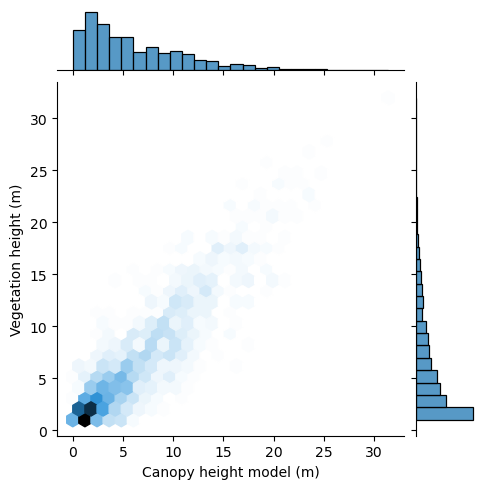

In [47]:
# How closely does the CHM match the vegetation height?
# Plot a scatter plot of the two variables
import seaborn as sns
from matplotlib import pyplot as plt

# Generate a modern looking scatter plot that shows the density of points by making then semi transparent
plot_subset = image_samples.sample(10000)
plot_subset = plot_subset[plot_subset["veg_height"] > 1]
plot = sns.jointplot(data=plot_subset, x="chm", y="veg_height", kind="hex", height=5)
# Add axis labels
plot.set_axis_labels("Canopy height model (m)", "Vegetation height (m)")

plot

There is a linear relationship between the vegetation height and the CHM but there is some error remaining. The are a lot of canopy height values which are >0 where the vegetation height is 0. This is consistent with what should be expected since the DSM will pick up features (like caravans) which have been removed by the algorithm which generates the vegetation height model. 

## Looking at Sentinel

For vegetation analysis using Sentinel-2 imagery:

- Red (B4): Useful for vegetation health.
- Green (B3): Also used in some vegetation indices.
- Near-Infrared (NIR, B8): Highly sensitive to vegetation.
- Short-Wave Infrared (SWIR, B11, B12): Helpful for moisture content.

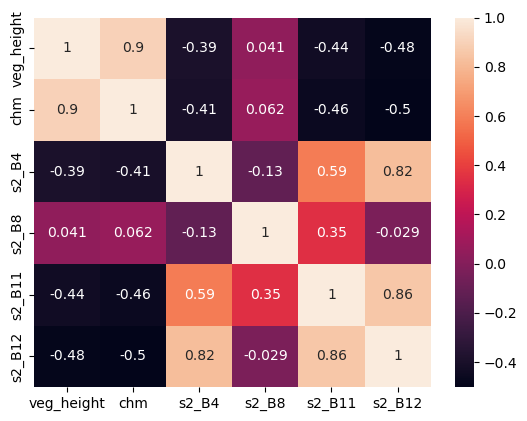

In [48]:
correlation_matrix = plot_subset[['veg_height', 'chm', 's2_B4', 's2_B8', 's2_B11', 's2_B12']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

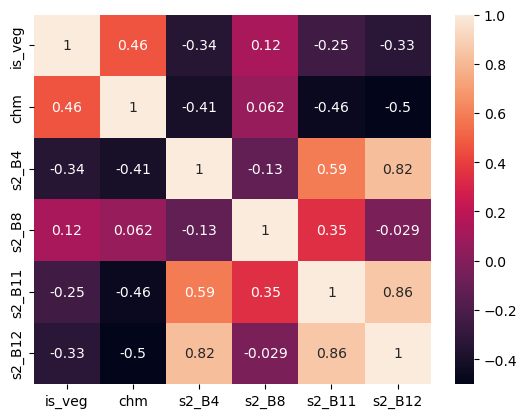

In [49]:
plot_subset["is_veg"] = plot_subset["veg_height"] > 2
correlation_matrix = plot_subset[['is_veg', 'chm', 's2_B4', 's2_B8', 's2_B11', 's2_B12']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

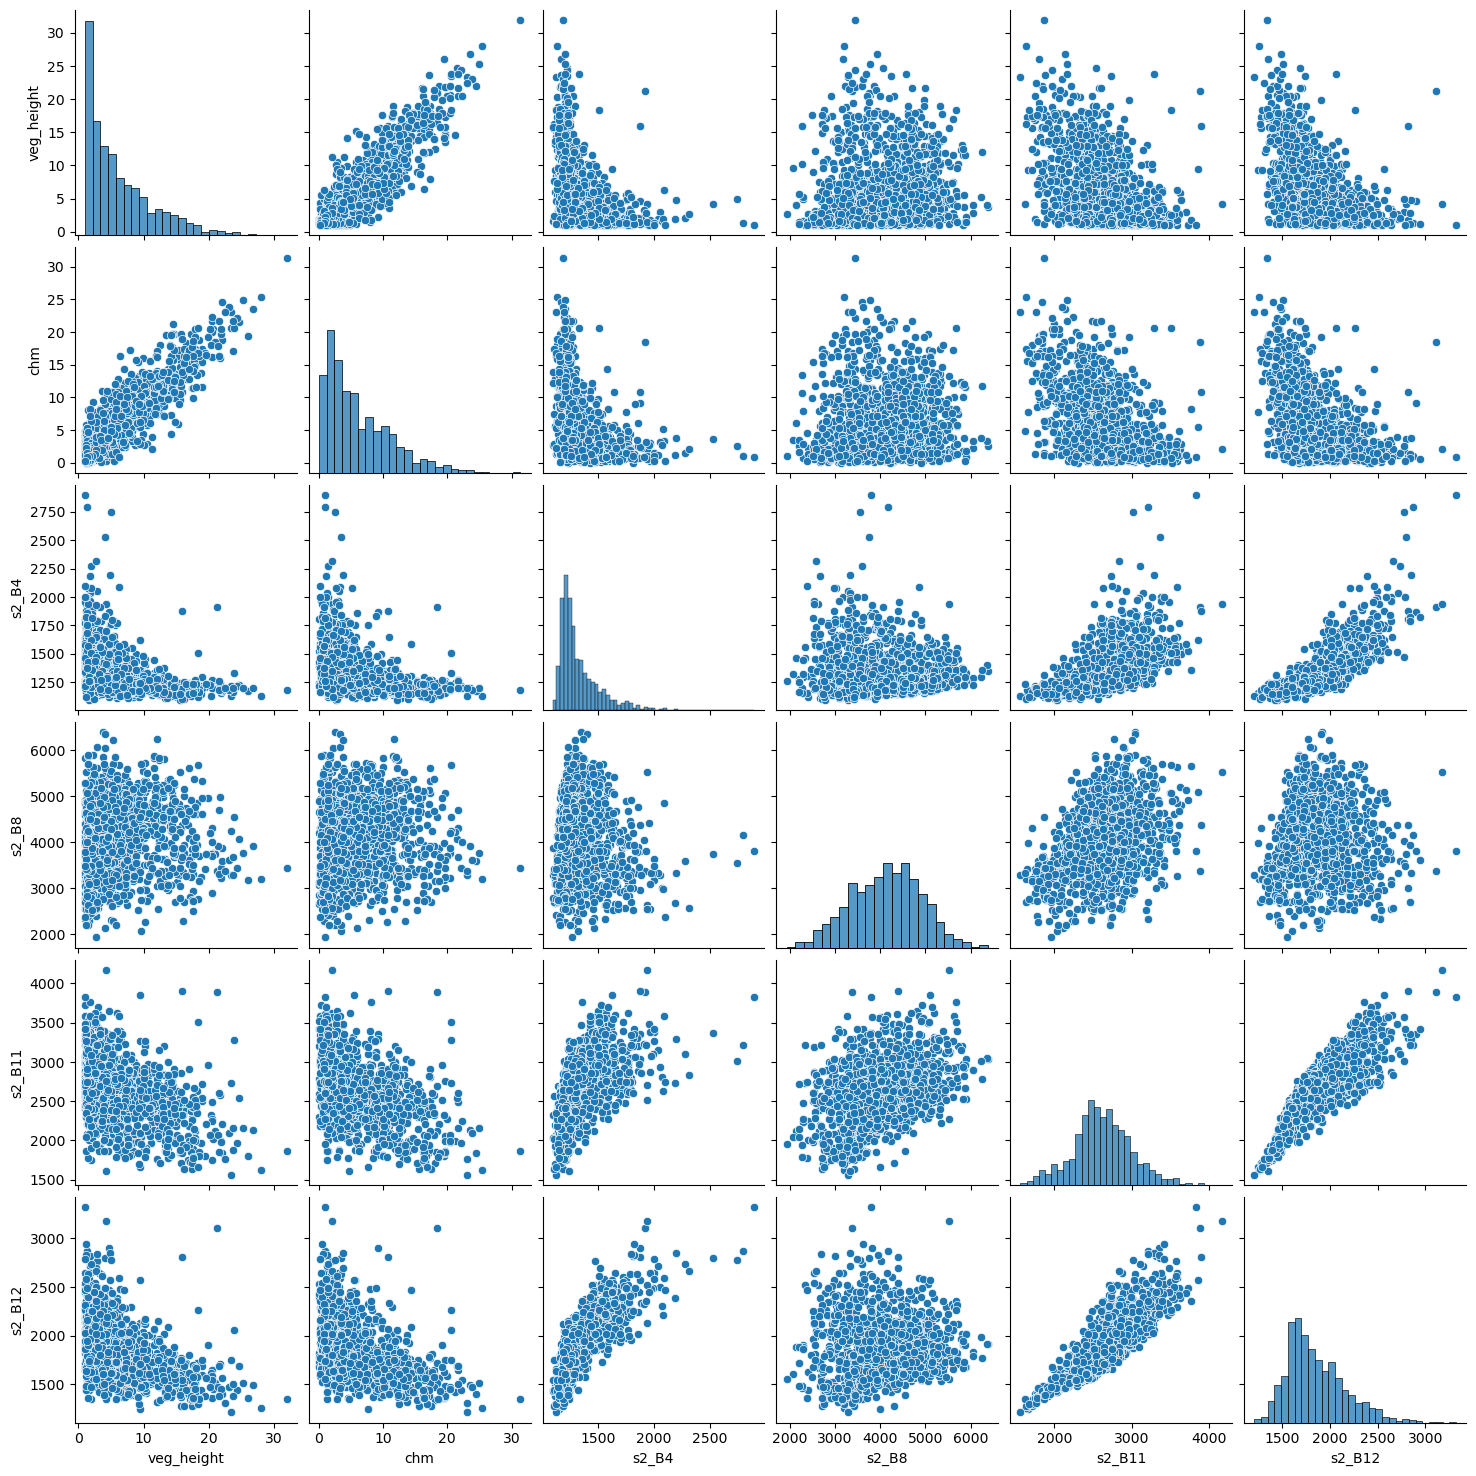

In [50]:
sns.pairplot(plot_subset[['veg_height', 'chm', 's2_B4', 's2_B8', 's2_B11', 's2_B12']])
plt.show()


# Modelling

First try to predict which pixels are vegetation and which are not. Then try to predict the vegetation height.

### Feature Engineering

In [51]:
# Identify vegetation
image_samples['is_veg'] = image_samples['veg_height'] > 2
image_samples['is_veg'] = image_samples['is_veg'].astype(int)

# NDVI
image_samples['ndvi'] = (image_samples['s2_B8'] - image_samples['s2_B4']) / (image_samples['s2_B8'] + image_samples['s2_B4'])

# NDWI
image_samples['ndwi'] = (image_samples['s2_B8'] - image_samples['s2_B11']) / (image_samples['s2_B8'] + image_samples['s2_B11'])

# Interaction of canopy height model and NDVI
image_samples['chm_ndvi'] = image_samples['chm'] * image_samples['ndvi']

# Soil adjusted vegetation index
image_samples['savi'] = ((image_samples['s2_B8'] - image_samples['s2_B4']) / (image_samples['s2_B8'] + image_samples['s2_B4'] + 0.5)) * (1.5)

# Enhanced vegetation index
image_samples['evi'] = 2.5 * ((image_samples['s2_B8'] - image_samples['s2_B4']) / (image_samples['s2_B8'] + 6 * image_samples['s2_B4'] - 7.5 * image_samples['s2_B2'] + 1))

image_samples.replace([np.inf, -np.inf], np.nan, inplace=True)
image_samples.dropna(inplace=True)

The model needs to differentiate between vegetation and non vegetation to then be able to accurately predict the vegetation height. I'm acheiving this by combining two random forest models in a pipeline

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
    # Check accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
# Make a naive version of the model


In [53]:
X_class = image_samples[['chm', 'ndvi', 'ndwi', 'chm_ndvi', 's2_B4', 's2_B8', 's2_B11', 's2_B12', 'savi', 'evi']]
y_class = image_samples['is_veg'].astype(int)
# Prepare data for regression
X_regress = image_samples[['chm', 'ndvi', 'dtm', 'dsm']]
y_regress = image_samples['veg_height']

# Naive Model


In [ ]:
mlflow.set_experiment('vegetation-height-simple')
with mlflow.start_run():
    # Prepare data for classification
    mlflow.log_param('features', X_class.columns.tolist())
    mlflow.log_param('n_samples', len(X_class))
    mlflow.log_param('class_balance', y_class.value_counts().to_dict())

    # Split data
    X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2)
    X_train_regress, X_test_regress, y_train_regress, y_test_regress = train_test_split(X_regress, y_regress, test_size=0.2)

    params = {'n_estimators': 200, 'max_depth': 10}
    mlflow.log_params(params)

    # Train a random forest classifier
    clf = RandomForestClassifier(n_jobs=-1, random_state=42, **params)
    clf.fit(X_train_class, y_train_class)

    # Make predictions
    y_pred_class = clf.predict(X_test_class)


    # Convert to binary
    y_pred_class = y_pred_class >= 2
    y_pred_class = y_pred_class.astype(int)

    # Then multiply the predicted values by the canopy height model
    # The veg height model is just the CHM but with non-vegetation areas set to 0
    y_pred = y_pred_class * X_test_regress['chm']

    # Then calculate the metrics
    mse = mean_squared_error(y_test_regress, y_pred)
    mae = mean_absolute_error(y_test_regress, y_pred)
    r2 = r2_score(y_test_regress, y_pred)
    # Log metrics
    mlflow.log_metric('mse', mse) # type: ignore
    mlflow.log_metric('mae', mae) # type: ignore
    mlflow.log_metric('r2', r2) # type: ignore


    cls_acc = accuracy_score(y_test_class, y_pred_class)
    mlflow.log_metric('cls_acc', cls_acc) # type: ignore

    # Precision and recall
    precision = precision_score(y_test_class, y_pred_class)
    recall = recall_score(y_test_class, y_pred_class)
    mlflow.log_metric('precision', precision) # type: ignore
    mlflow.log_metric('recall', recall) # type: ignore

    mlflow.set_tag("model_type", "Random Forest Classification: 0,1 x CHM")

    print(f'Classification accuracy: {cls_acc:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'MSE: {mse:.2f}')
    print(f'MAE: {mae:.2f}')
    print(f'R2: {r2:.2f}')

    # Log model
    mlflow.sklearn.log_model(clf, 'model')



# Classification & Regression Models

In [56]:
from sklearn.ensemble import RandomForestRegressor


class VegetationRFModel:
    def __init__(self, cls_params: dict, reg_params: dict, n_jobs: int = -1):
        self.cls_model = RandomForestClassifier(
            n_jobs=n_jobs, random_state=42, **cls_params
        )
        self.reg_model = RandomForestRegressor(
            n_jobs=n_jobs, random_state=42, **reg_params
        )
        self.fitted = False

    def fit(self, X: np.ndarray, y: np.ndarray):
        # Convert vegetation height to a binary class - is it vegetation or not?
        y_class = y >= 2.0
        self.cls_model.fit(X, y_class)

        # Add the predicted class as a feature
        is_veg = self.cls_model.predict(X)
        is_veg = is_veg[:, np.newaxis]
        X = np.hstack([X, is_veg])
        # Fit the regression model
        self.reg_model.fit(X, y)
        self.fitted = True

    def predict(self, X: np.ndarray):
        # Predict the class
        is_veg = self.cls_model.predict(X)
        is_veg = is_veg[:, np.newaxis]
        X = np.hstack([X, is_veg])
        # Predict the vegetation height
        return self.reg_model.predict(X)

    def cls_accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        y_pred = self.cls_model.predict(X)
        y_class = y >= 2.0
        y_class = y_class.astype(int)
        return accuracy_score(y_class, y_pred)

    def score(self, X: np.ndarray, y: np.ndarray) -> dict:
        y_pred = self.predict(X)
        mse = mean_squared_error(y, y_pred)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)

        return {"mse": mse, "mae": mae, "r2": r2}


X = image_samples[
    [
        "chm",
        "ndvi",
        "ndwi",
        "chm_ndvi",
        "s2_B4",
        "s2_B8",
        "s2_B11",
        "s2_B12",
        "savi",
        "evi",
    ]
]
y = image_samples["veg_height"]

with mlflow.start_run():
    model_cls_rgr = VegetationRFModel(
        cls_params={"n_estimators": 200, "max_depth": 10},
        reg_params={"n_estimators": 200, "max_depth": 10},
    )

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit the model
    model_cls_rgr.fit(X_train, y_train)

    # Log the model
    mlflow.sklearn.log_model(model_cls_rgr, "model")

    # Log the parameters
    mlflow.log_params(model_cls_rgr.cls_model.get_params())

    # Log the model type
    mlflow.set_tag("model_type", "Random Forest Classification and Regression")

    # Log the metrics
    metrics = model_cls_rgr.score(X_test, y_test)
    mlflow.log_metrics(metrics)
    print(metrics)
    # Log classification accuracy
    mlflow.log_metric("cls_acc", model_cls_rgr.cls_accuracy(X_test, y_test))

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


{'mse': 1.063755231234607, 'mae': 0.3752807257231847, 'r2': 0.8813444331839538}


# Try a Deep Learning Approach

In [31]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import mlflow.pytorch
from sklearn.preprocessing import StandardScaler
# s2_B1	s2_B2	s2_B3	s2_B4	s2_B5	s2_B6	s2_B7	s2_B8	s2_B8A	s2_B9	s2_B11	s2_B12

X = image_samples[['chm', 'dtm', 'dsm', 's2_B1', 's2_B2', 's2_B3', 's2_B4', 's2_B5', 's2_B6', 's2_B7', 's2_B8', 's2_B8A', 's2_B9', 's2_B11', 's2_B12']].values
y = image_samples['veg_height'].values

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Convert your data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network model
class VegHeightModel(nn.Module):
    def __init__(self):
        super(VegHeightModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss, and optimizer
model_nn = VegHeightModel()
criterion = nn.MSELoss()
lr = 0.001
optimizer = optim.Adam(model_nn.parameters(), lr=lr)

epochs = 10

# Training loop
for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_mae = 0.0
    for batch_X, batch_y in train_loader:
        # Zero gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model_nn(batch_X)
        loss = criterion(outputs, batch_y.view(-1, 1))
        mae = torch.mean(torch.abs(outputs - batch_y.view(-1, 1)))
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_mae += mae.item()
    
    # Calculate average epoch loss and MAE
    avg_epoch_loss = epoch_loss / len(train_loader)
    avg_epoch_mae = epoch_mae / len(train_loader)
    
    # Print or log the average loss and MAE for the epoch
    print(f'Epoch {epoch+1}, Avg Loss: {avg_epoch_loss}, Avg MAE: {avg_epoch_mae}')


# Log the model with MLflow
with mlflow.start_run() as run:
    mlflow.log_param("Epochs", epochs)
    mlflow.log_param("features", X_train.shape[1])
    mlflow.pytorch.log_model(model_nn, "model")
    mlflow.log_param('learning_rate', lr)

    # Test the model
    model_nn.eval()
    with torch.no_grad():
        test_outputs = model_nn(X_test_tensor)
        mse = criterion(test_outputs, y_test_tensor.view(-1, 1))
        mae = torch.mean(torch.abs(test_outputs - y_test_tensor.view(-1, 1)))

        print(f'Test MSE: {mse.item()}')
        print(f'Test MAE: {mae.item()}')

        mlflow.log_metric('mse', mse.item())
        mlflow.log_metric('mae', mae.item())


Epoch 1, Avg Loss: 1.101974799343337 
Avg MAE: 0.3983764884678381
Epoch 2, Avg Loss: 1.0707249877661131 
Avg MAE: 0.3867398073391323
Epoch 3, Avg Loss: 1.066073180635832 
Avg MAE: 0.38603612169416907
Epoch 4, Avg Loss: 1.0634298278322687 
Avg MAE: 0.38360508886293865
Epoch 5, Avg Loss: 1.0621627504501743 
Avg MAE: 0.3813617418426232
Epoch 6, Avg Loss: 1.060962101887694 
Avg MAE: 0.3811845570604977
Epoch 7, Avg Loss: 1.0603192909988417 
Avg MAE: 0.38098406474849605
Epoch 8, Avg Loss: 1.059144017008679 
Avg MAE: 0.38093229742011325
Epoch 9, Avg Loss: 1.0582223264903066 
Avg MAE: 0.38072087886415146
Epoch 10, Avg Loss: 1.058127069387448 
Avg MAE: 0.38053588842930863


/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Test MSE: 1.0512689352035522
Test MAE: 0.37875935435295105


# Make Predictions

In [69]:
# Raster calcs
def calculate_chm(dsm, dtm):
    return dsm - dtm

def calculate_ndvi(b4, b8):
    return (b8 - b4) / (b8 + b4)

def calculate_ndwi(b8, b11):
    return (b8 - b11) / (b8 + b11)

def calculate_savi(b4, b8):
    return ((b8 - b4) / (b8 + b4 + 0.5)) * (1.5)

def calculate_evi(b4, b8, b2):
    return 2.5 * ((b8 - b4) / (b8 + 6 * b4 - 7.5 * b2 + 1))


In [72]:
# Predict the vegetation height across the whole area
# Select and arrange the bands

image_predict = image_stack.copy()
image_predict = image_predict.where(image_predict != -9999, np.nan)
image_predict

image_predict['chm'] = calculate_chm(image_predict['dsm'], image_predict['dtm'])
image_predict['ndvi'] = calculate_ndvi(image_predict['s2_B4'], image_predict['s2_B8'])
image_predict['ndwi'] = calculate_ndwi(image_predict['s2_B8'], image_predict['s2_B11'])
image_predict['savi'] = calculate_savi(image_predict['s2_B4'], image_predict['s2_B8'])
image_predict['evi'] = calculate_evi(image_predict['s2_B4'], image_predict['s2_B8'], image_predict['s2_B2'])
image_predict['chm_ndvi'] = image_predict['chm'] * image_predict['ndvi']

input_vars =     [
        "chm",
        "ndvi",
        "ndwi",
        "chm_ndvi",
        "s2_B4",
        "s2_B8",
        "s2_B11",
        "s2_B12",
        "savi",
        "evi",
    ]

image_predict = image_predict[input_vars]

In [74]:
image_predict.compute()

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:      (y: 4212, x: 10988)
Coordinates:
  * x            (x) float64 -1.837 -1.837 -1.837 ... -0.8506 -0.8505 -0.8504
  * y            (y) float64 53.67 53.67 53.67 53.67 ... 53.29 53.29 53.29 53.29
    spatial_ref  int64 0
    band         int64 1
Data variables:
    chm          (y, x) float32 nan nan nan ... -0.0008411 -0.0006466 -0.0006466
    ndvi         (y, x) float64 0.5124 0.5029 0.5029 ... 0.2995 0.2995 0.2784
    ndwi         (y, x) float64 0.1218 0.1213 0.1213 ... 0.1563 0.1563 0.1391
    chm_ndvi     (y, x) float64 nan nan nan ... -0.0002519 -0.0001937 -0.00018
    s2_B4        (y, x) float64 1.518e+03 1.556e+03 ... 1.933e+03 1.954e+03
    s2_B8        (y, x) float64 4.708e+03 4.704e+03 ... 3.586e+03 3.462e+03
    s2_B11       (y, x) float64 3.686e+03 3.686e+03 ... 2.616e+03 2.616e+03
    s2_B12       (y, x) float64 2.499e+03 2.499e+03 ... 2.308e+03 2.308e+03
    savi         (y, x) float64 0.7685 0.7543 0.7543 ... 0.4492 0.4492 0.4176
    evi          (y, x) float64 2.579 2.474 2.474 2.632 ... 0.9497 0.9497 0.9414
Attributes:
    AREA_OR_POINT:  Area
    long_name:      ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', '...

In [109]:

import dask.array as da
import numpy as np

# Convert to a dask array
predict_array = da.from_array(image_predict.to_array(dim='band'), chunks=(10, 1500, 1500))  # Adjust chunks as needed

shape_3d = predict_array.shape

# Reshape the array to be 2D
predict_array = predict_array.compute().reshape((-1, shape_3d[0]))


predict_array = da.from_array(predict_array, chunks= (10, 10000))

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/array/core.py:3470: UserWarning: Passing an object to dask.array.from_array which is already a Dask collection. This can lead to unexpected behavior.
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [115]:
from dask.array.ma import masked_array
nan_or_inf_mask = np.isnan(predict_array) | np.isinf(predict_array)

masked_predict_array = masked_array(predict_array, mask= nan_or_inf_mask)

masked_predict_array

dask.array<masked_array, shape=(46281456, 10), dtype=float64, chunksize=(10, 10), chunktype=numpy.MaskedArray>

In [118]:

# Create a function to apply the model
def apply_model(block, model):
    # Predict
    block_prediction = model.predict(block)
    
    return block_prediction


# Apply model
result = predict_array.map_blocks(apply_model, model=model_cls_rgr, dtype=np.float64)


# Compute result
from dask.diagnostics import ProgressBar

with ProgressBar():
    computed_result = result.compute(scheduler = "processes")

veg_height_prediction = computed_result.reshape(shape_3d)

veg_height_prediction

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[                                        ] | 0% Completed | 175.46 ss

/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[                                        ] | 0% Completed | 175.67 s


/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matthewwhittle/opt/miniconda3/envs/bats/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
veg_height_prediction = computed_result.reshape(shape_3d)